In [1]:
import numpy as np

datall_testing = np.load('../../data/ToC2ME_Testing_data_for_model_20241022/datall.npy')
polall_testing = np.load('../../data/ToC2ME_Testing_data_for_model_20241022/polall.npy')

print(datall_testing.shape)
print(polall_testing.shape)

(2861, 600, 1)
(2861,)


1


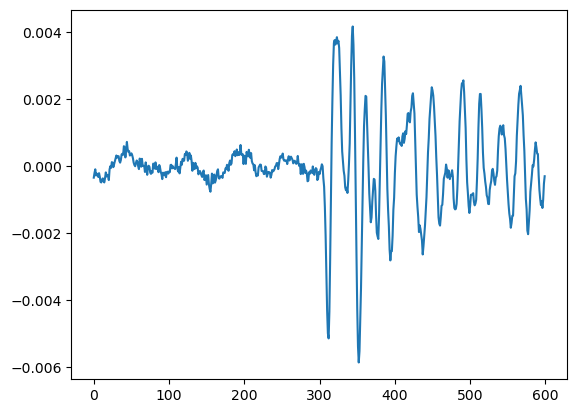

In [2]:
#Check the waveform and corresponding polarity

import matplotlib.pyplot as plt
plt.plot(datall_testing[1,:])
print(polall_testing[1])

In [3]:
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from tensorflow.keras.layers import Bidirectional, concatenate, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import CSVLogger
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from tensorflow.python.keras.layers import Layer, InputSpec
# import tensorflow as tf
# tf.compat.v1.reset_default_graph()
from sklearn.metrics import accuracy_score

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten, Reshape, multiply
from keras.layers import concatenate, GRU, Input, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
# from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.models import Model


2024-11-18 09:42:10.558091: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 09:42:10.597872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 09:42:10.597904: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 09:42:10.597933: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 09:42:10.605451: I tensorflow/core/platform/cpu_feature_g

In [4]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        #x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [5]:
drop_rate = 0.2
stochastic_depth_rate = 0.1

w1 = 100

positional_emb = False
conv_layers = 2
num_classes = 1
input_shape = (600,1)
image_size = 600  # We'll resize input images to this size
projection_dim = int(2*w1)
num_heads = 4
transformer_units = [
    projection_dim,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4

In [6]:
import tensorflow as tf
class CCTTokenizer1(layers.Layer):
    def __init__(
        self,
        kernel_size=4,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=(2,2,2,2,2,2,2,2),
        num_conv_layers=conv_layers,
        num_output_channels=[int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim)],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer1, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = tf.keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv1D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="same",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            #self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool1D(pooling_kernel_size, (pooling_stride[i]), "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, 1))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = dummy_outputs.shape[1]
            projection_dim = dummy_outputs.shape[-1]

            print(dummy_outputs,sequence_length,projection_dim)
            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [7]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [8]:
#def create_vit_classifier(inputs):
def create_cct_model1(inputs):


    # Augment data.
    #augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer1()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)

        #print(encoded_patches)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        #x3 = x2
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)

        # Skip connection 2.
        #print(x3)
        x3 = StochasticDepth(dpr[i])(x3)
        #print(x3)
        encoded_patches = layers.Add()([x3, x2])
     
    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    
    ''' 
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)
    '''
    return representation

In [9]:
inputs = layers.Input(shape=input_shape,name='input')

featuresP = create_cct_model1(inputs)
#featuresP = layers.Dropout(0.2)(featuresP)
featuresP = layers.Flatten()(featuresP)
logitp = layers.Dense(1, activation='sigmoid')(featuresP)


#logitp  = Conv2D(1,  3, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_P')(featuresP)


model = Model(inputs=[inputs], outputs=[logitp])
model.summary()


2024-11-18 09:42:28.841956: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 600, 1)]             0         []                            
                                                                                                  
 cct_tokenizer1 (CCTTokeniz  (None, 150, 200)             160800    ['input[0][0]']               
 er1)                                                                                             
                                                                                                  
 layer_normalization (Layer  (None, 150, 200)             400       ['cct_tokenizer1[0][0]']      
 Normalization)                                                                                   
                                                                                              

In [10]:
inputs = layers.Input(shape=input_shape,name='input')

featuresP = create_cct_model1(inputs)
featuresP = layers.Flatten()(featuresP)
featuresP = layers.Dropout(0.2)(featuresP)
logitp = layers.Dense(1, activation='sigmoid')(featuresP)


#logitp  = Conv2D(1,  3, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_P')(featuresP)


model = Model(inputs=[inputs], outputs=[logitp])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 600, 1)]             0         []                            
                                                                                                  
 cct_tokenizer1_1 (CCTToken  (None, 150, 200)             160800    ['input[0][0]']               
 izer1)                                                                                           
                                                                                                  
 layer_normalization_9 (Lay  (None, 150, 200)             400       ['cct_tokenizer1_1[0][0]']    
 erNormalization)                                                                                 
                                                                                            

In [11]:
#Load Model
import h5py

model.load_weights('../../model/Texas/best_weigths_Binary_Texas_Transfer10.h5')


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

out_Texas = model.predict(datall_testing,batch_size=1024, verbose=1)
print(out_Texas.shape)
print(out_Texas)

3/3 [==============================] - 11s 3s/step
(2861, 1)
[[0.9774794 ]
 [0.89806205]
 [0.99821126]
 ...
 [0.99982834]
 [0.9993288 ]
 [0.9986628 ]]


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#outtest = np.argmax(out,axis=-1)
thre = 0.5
outtest = out_Texas.copy()
outtest[outtest<thre]=0
outtest[outtest>=thre]=1
labtest = polall_testing

accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='micro'),recall_score(labtest,outtest, average='micro'),f1_score(labtest,outtest, average='micro')

(0.9147151345683328,
 0.9147151345683328,
 0.9147151345683328,
 0.9147151345683328)

In [15]:
#Load Model
import h5py

model.load_weights('../../model/SCSN/best_weigths_Binary_SCSN_Best.h5')


In [16]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

out_SCSN = model.predict(datall_testing,batch_size=1024, verbose=1)
print(out_SCSN.shape)
print(out_SCSN)

3/3 [==============================] - 10s 3s/step
(2861, 1)
[[0.68545467]
 [0.32353112]
 [0.9201684 ]
 ...
 [0.6028636 ]
 [0.9016589 ]
 [0.76414275]]


In [17]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#outtest = np.argmax(out,axis=-1)
thre = 0.5
outtest = out_SCSN.copy()
outtest[outtest<thre]=0
outtest[outtest>=thre]=1
labtest = polall_testing

accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='micro'),recall_score(labtest,outtest, average='micro'),f1_score(labtest,outtest, average='micro')

(0.6994058021670745,
 0.6994058021670745,
 0.6994058021670745,
 0.6994058021670745)

In [18]:
#Load Model
import h5py

model.load_weights('../../model/Toc2me_20240819_Transfer_Learning_21916data/best_weigths_Binary_Toc2me_Transfer_SCSN_20241013_21916data_90.h5')


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

out_Toc2me_90per = model.predict(datall_testing,batch_size=1024, verbose=1)
print(out_Toc2me_90per.shape)
print(out_Toc2me_90per)

3/3 [==============================] - 10s 3s/step
(2861, 1)
[[0.99995583]
 [0.99995184]
 [0.9999924 ]
 ...
 [0.9999678 ]
 [0.99999917]
 [0.99998635]]


In [20]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#outtest = np.argmax(out,axis=-1)
thre = 0.5
outtest = out_Toc2me_90per.copy()
outtest[outtest<thre]=0
outtest[outtest>=thre]=1
labtest = polall_testing

accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='micro'),recall_score(labtest,outtest, average='micro'),f1_score(labtest,outtest, average='micro')

(0.9919608528486543,
 0.9919608528486543,
 0.9919608528486543,
 0.9919608528486543)

Thresholds range for Texas: min=7.646766553293105e-11, max=0.9999999403953552
2824
Thresholds range for SCSN: min=0.00012069532385794446, max=0.999555766582489
2860
Thresholds range for Toc2ME: min=1.1793571761536947e-13, max=1.0
1933


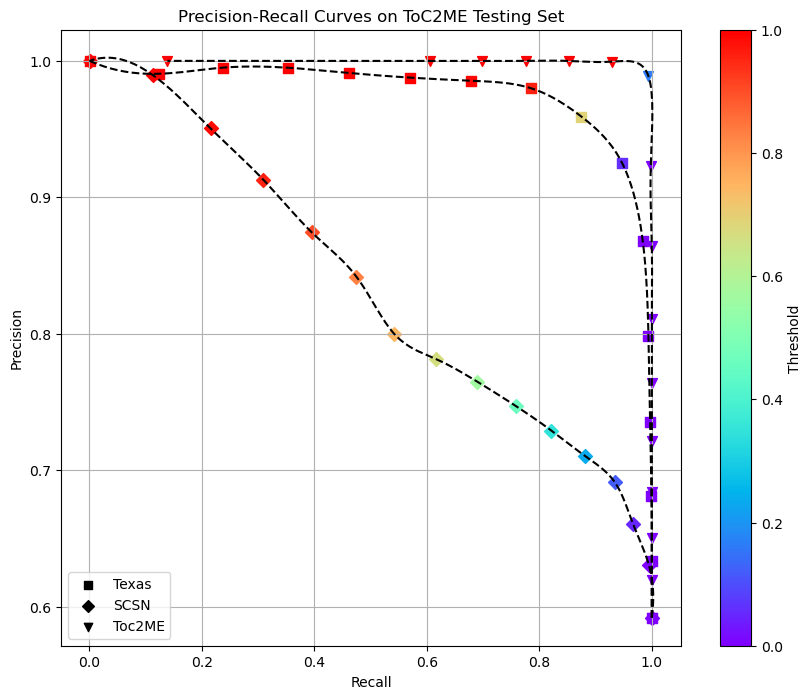

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from scipy.interpolate import make_interp_spline

# Assume the model outputs are out_Texas, out_SCSN, and out_Toc2me_90per, and labtest is the true labels
labtest = polall_testing.copy()

# Model prediction outputs
out_Texas = out_Texas.copy()  # Model 1: Texas
out_SCSN = out_SCSN.copy()    # Model 2: SCSN
out_Toc2me_90per = out_Toc2me_90per.copy()  # Model 3: Toc2me 90%

# Function to plot the PR curve for different models, with parameterized interpolation of 16 points
def plot_pr_curve(outtest, label, marker, size=50):  # Default marker size is 50
    # Calculate the precision-recall curve
    precision, recall, thresholds = precision_recall_curve(labtest, outtest)

    # Filter precision and recall values between 0 and 1
    mask = (precision[:-1] >= 0) & (precision[:-1] <= 1) & (recall[:-1] >= 0) & (recall[:-1] <= 1)

    # Filter precision, recall, and thresholds based on the mask
    precision_filtered = precision[:-1][mask]
    recall_filtered = recall[:-1][mask]
    thresholds_filtered = thresholds[mask]
    print(f"Thresholds range for {label}: min={thresholds.min()}, max={thresholds.max()}")
    
    print(len(thresholds))
    # Select approximately 16 points for annotation
    num_points = 16
    if len(thresholds_filtered) > 0:
        indices = np.linspace(1, len(thresholds_filtered) - 1, num_points, dtype=int)

        # Extract the 16 selected points
        recall_selected = recall_filtered[indices]
        precision_selected = precision_filtered[indices]

        # Parametric interpolation: using t as a parameter
        t = np.linspace(0, 1, len(recall_selected))  # Parameter t
        t_new = np.linspace(0, 1, 300)  # New parameter for interpolation

        # Interpolate recall and precision values
        recall_spline = make_interp_spline(t, recall_selected, k=3)(t_new)
        precision_spline = make_interp_spline(t, precision_selected, k=3)(t_new)

        # Plot the smoothed black dashed line curve
        plt.plot(recall_spline, precision_spline, color='black', linestyle='--')

        # Map the thresholds to colors using a rainbow colormap
        norm = plt.Normalize(vmin=thresholds_filtered.min(), vmax=thresholds_filtered.max())
        cmap = plt.get_cmap('rainbow')

        # Annotate the PR curve with markers corresponding to each threshold
        for i in indices:
            thre = thresholds_filtered[i]
            plt.scatter(recall_filtered[i], precision_filtered[i], color=cmap(norm(thre)), marker=marker, s=size)

# Create the figure and set the figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the PR curve for three different models with different markers and smaller marker sizes
plot_pr_curve(out_Texas, 'Texas', marker='s', size=50)  # Texas with solid squares, size 50
plot_pr_curve(out_SCSN, 'SCSN', marker='D', size=50)    # SCSN with solid diamonds, size 50
plot_pr_curve(out_Toc2me_90per, 'Toc2ME', marker='v', size=50)  # Toc2me with solid triangles, size 50

# Add a colorbar to represent different threshold values
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('rainbow'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Threshold')

# Add title and labels to the plot
plt.title('Precision-Recall Curves on ToC2ME Testing Set')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

# Create black markers to add to the legend
plt.scatter([], [], color='black', marker='s', label='Texas')
plt.scatter([], [], color='black', marker='D', label='SCSN')
plt.scatter([], [], color='black', marker='v', label='Toc2ME')

# Add legend
plt.legend()

# Save the image
plt.savefig('precision_recall_curves_ToC2ME.png', dpi=300, bbox_inches='tight')

# Show the image
plt.show()


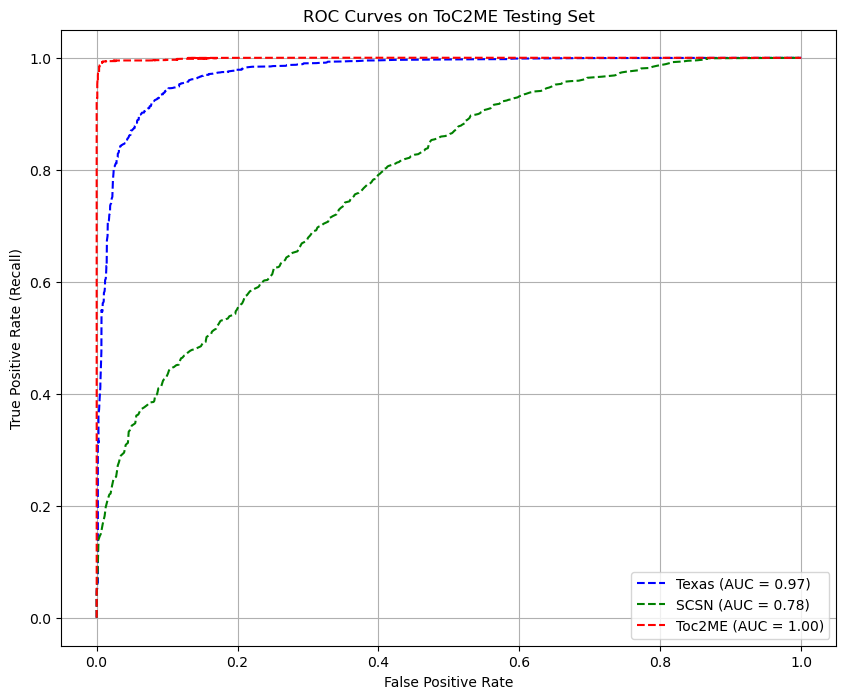

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import make_interp_spline

# Assume the model outputs are out_Texas, out_SCSN, and out_Toc2me_90per, and labtest is the true labels
labtest = polall_testing.copy()

# Model prediction outputs
out_Texas = out_Texas.copy()  # Model 1: Texas
out_SCSN = out_SCSN.copy()    # Model 2: SCSN
out_Toc2me_90per = out_Toc2me_90per.copy()  # Model 3: Toc2me 90%

# Function to plot the ROC curve for different models
def plot_roc_curve(outtest, label, color):  # Default marker size is 50
    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labtest, outtest)
    roc_auc = auc(fpr, tpr)

    # Filter FPR and TPR values between 0 and 1
    mask = (fpr >= 0) & (fpr <= 1) & (tpr >= 0) & (tpr <= 1)

    # Filter FPR and TPR based on the mask
    fpr_filtered = fpr[mask]
    tpr_filtered = tpr[mask]
    
    # Select all points for smoothing
    t = np.linspace(0, 1, len(fpr_filtered))  # Parametric variable t
    t_new = np.linspace(0, 1, 300)  # New parametric variable for interpolation

    # Interpolate FPR and TPR values
    fpr_spline = make_interp_spline(t, fpr_filtered, k=3)(t_new)
    tpr_spline = make_interp_spline(t, tpr_filtered, k=3)(t_new)

    # Plot the smoothed curve using the specified color
    plt.plot(fpr_spline, tpr_spline, color=color, linestyle='--', label=f'{label} (AUC = {roc_auc:.2f})')

# Create the figure and set the figure size
plt.figure(figsize=(10, 8))

# Plot the ROC curve for three different models, without threshold annotations, only smoothed curves with different colors
plot_roc_curve(out_Texas, 'Texas', color='blue')  # Texas with blue color
plot_roc_curve(out_SCSN, 'SCSN', color='green')   # SCSN with green color
plot_roc_curve(out_Toc2me_90per, 'Toc2ME', color='red')  # Toc2me with red color

# Add title and labels
plt.title('ROC Curves on ToC2ME Testing Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)

# Add the legend
plt.legend(loc='lower right')

# Save the image
plt.savefig('roc_curves_ToC2ME.png', dpi=300, bbox_inches='tight')

# Display the image
plt.show()


In [37]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(labtest, outtest)

print(cf_matrix)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

cf = cf_matrix
categories=['Up','Down']
group_percentages = []
counts = []
for i in range(len(cf)):
    for j in range(len(cf)):
        group_percentages.append(cf[j, i]/np.sum(cf[:, i]))
        counts.append(cf[j, i])

percentages_matrix = np.reshape(group_percentages, (2, 2))
group_percentages = ['{0:.2%}'.format(value) for value in group_percentages]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, counts)]
labels = np.asarray(labels).reshape(2, 2, order = 'F')

fig = plt.figure(figsize=(10,7))
sn.set(font_scale=2) # for label size
sn.heatmap(percentages_matrix, annot = labels, fmt = '', xticklabels=categories, yticklabels = categories, cbar = False)

# Save the figure
save_path = './confusion_matrix.png'
fig.savefig(save_path, bbox_inches='tight', transparent=True, dpi=100)
plt.close(fig)  # Close the figure after saving

[[1156   12]
 [  11 1682]]
